In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

2024-02-26 11:54:59.088223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/motif_level/')
csv_dir = '../results/summary_csvs/enformer/motif_analysis/'
thresholds = [float(i) for i in result_dir.split('_')[-1].split('/')[0].split(',')]
thresholds


NameError: name 'result_dir' is not defined

# XSTREME

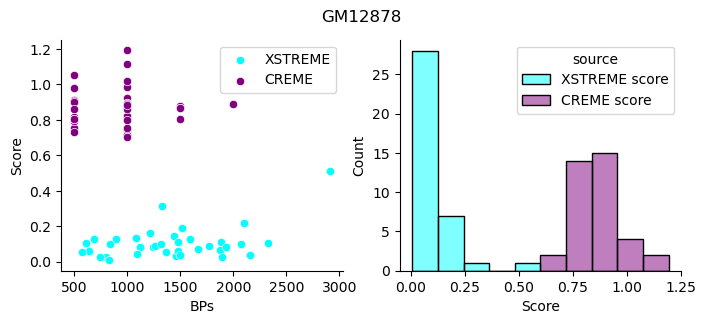

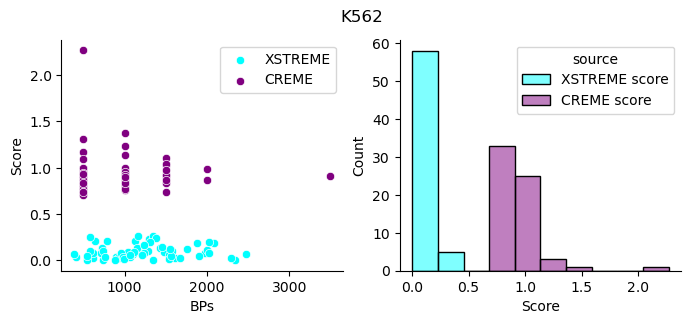

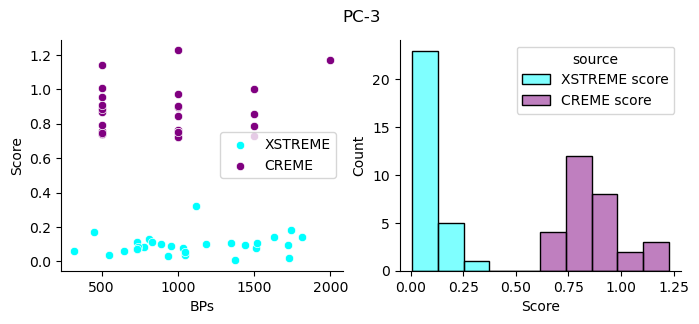

In [5]:
dfs = pd.read_csv(f"{csv_dir}/XSTREME_vs_CREME.csv")
for cell_line, df in dfs.groupby('cell_line'):
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])

    sns.scatterplot(data=df, x='XSTREME bps', y='XSTREME score', color='cyan', label='XSTREME', ax=axes[0])
    sns.scatterplot(data=df, x='CREME bps', y='CREME score', color='purple', label='CREME', ax=axes[0])
    axes[0].set_xlabel('BPs')
    axes[0].set_ylabel('Score')
    melted_df = df[['XSTREME score', 'CREME score']].melt(value_name='Score', var_name='source')
    sns.histplot(data=melted_df, x='Score', hue='source', bins=10, palette={'XSTREME score': 'cyan', 'CREME score': 'purple'}, ax=axes[1])

    # axes[1].set_xlabel('Score')


    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.legend()
    fig.suptitle(cell_line)
    
    fig.savefig(f"{pdf_dir}/XSTRME_vs_CREME_{cell_line}.pdf")
    plt.show()

# CREME vs Saliency vs XSTREME

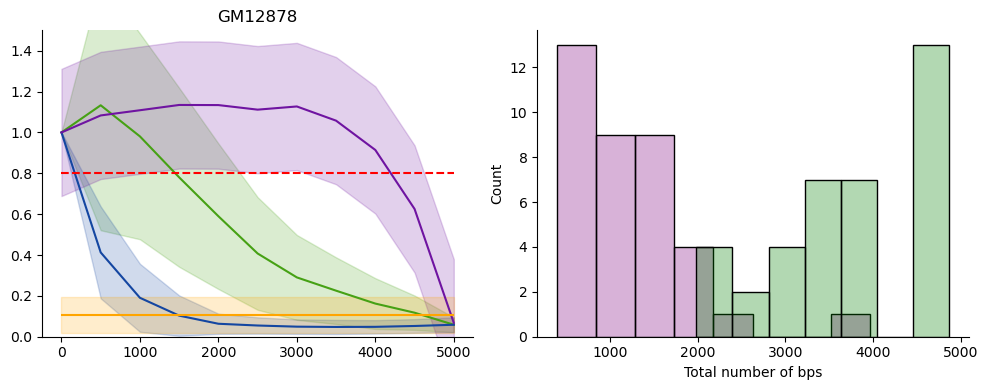

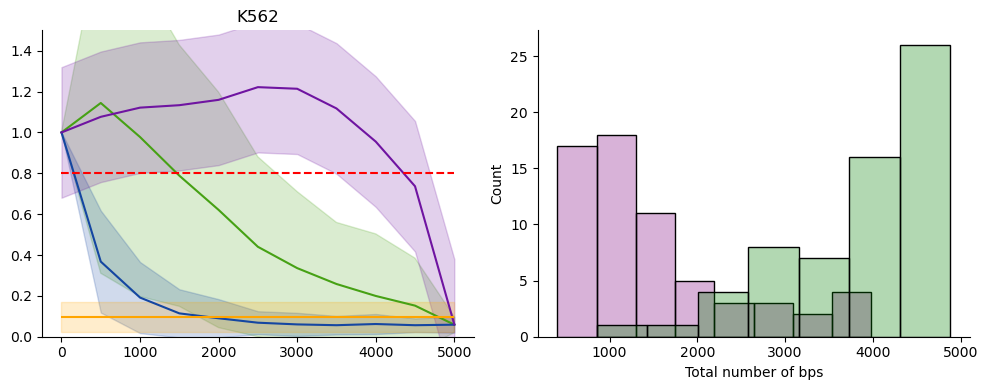

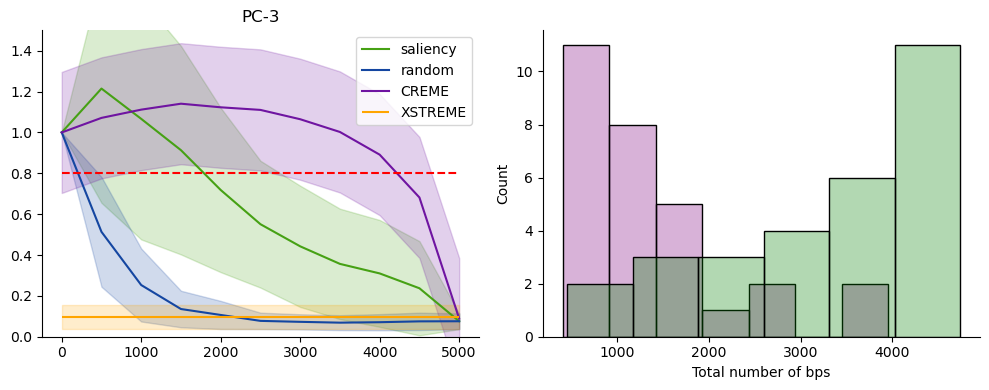

In [7]:
dfs = pd.read_csv(f"{csv_dir}/CREME_vs_saliency_vs_XSTREME.csv")
threshold_for_plotting = 0.8
c = ['#46a114', '#1446a1', '#a16f14']
for a, (cell_line, cell_df) in enumerate(dfs.groupby('cell_line')):
    fig, axes = plt.subplots(1, 2, figsize=[10, 4])

    ax = axes[0]
    bps = np.arange(0, 5001, 500)
    mean_set = {'saliency': [], 'random': []}
    mean_set_CREME = []
    xstreme_scores = []
    bps_at_thresh = {'saliency': [], 'CREME': []}
    for s, (seq_tile_id, one_seq_df) in enumerate(cell_df.groupby('seq_id')): 

        
        frac = one_seq_df['CREME score']
        mean_set_CREME.append(frac) # save to compute mean line
        

        mean_set['saliency'].append(one_seq_df['Saliency score']) 
        mean_set['random'].append(one_seq_df['Random score']) 
        #XSTREME results
        
        xstreme_scores.append(one_seq_df['XSTREME score'].values[0])
        bps_at_thresh['saliency'].append(5000 - interp1d(one_seq_df['Saliency score'], bps)(threshold_for_plotting))
        bps_at_thresh['CREME'].append(5000-interp1d(frac, bps[:len(frac)])(threshold_for_plotting))
        
        
        
        
    longest_i = np.argmax([len(l) for l in mean_set_CREME])

    mean_set_CREME = np.array([np.pad(a, mode='constant',constant_values=(np.nan,),
                                      pad_width=(0, len(mean_set_CREME[longest_i])-len(a))) for a in mean_set_CREME])
    mean_set_CREME = np.nanmean(mean_set_CREME, axis=0)
    std_set_CREME = np.nanstd(mean_set_CREME, axis=0)

    for j, (k, v) in enumerate(mean_set.items()):
        mean = np.array(v).mean(axis=0)
        std = np.array(v).std(axis=0)
        ax.fill_between(bps, mean-std, mean+std, color=c[j], alpha=.2)
        ax.plot(bps, np.array(v).mean(axis=0), label=k, color=c[j])
        


    
    ax.plot(np.arange(0, 5500, 500), mean_set_CREME, label='CREME', color='#6f14a1')
    ax.fill_between(np.arange(0, 5500, 500), mean_set_CREME-std_set_CREME, mean_set_CREME+std_set_CREME, color='#6f14a1', alpha=.2)
    ax.hlines(threshold_for_plotting, 0, 5000, linestyle='--', color='r')
    # ax.hlines(thresholds[1], 0, 5000, linestyle='--', color='r', label='CREME threshold 50bp')
    xstreme_mean = np.mean(xstreme_scores)
    xstreme_std = np.std(xstreme_scores)

    ax.hlines(xstreme_mean, 0, 5000, color='orange', label='XSTREME')
    ax.fill_between(np.arange(0, 5500, 500), xstreme_mean-xstreme_std, xstreme_mean+xstreme_std, color='orange', alpha=.2)
    if a==2:
        ax.legend(bbox_to_anchor=[1,1])
    ax.set_title(cell_line)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_xlim(0, 4500)
    ax.set_ylim(0, 1.5)
    
    sns.histplot(bps_at_thresh['CREME'], color='purple', ax=axes[1], alpha=0.3)
    sns.histplot(bps_at_thresh['saliency'], color='green', ax=axes[1], alpha=0.3)

    plt.xlabel('Total number of bps')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    plt.tight_layout()
    fig.savefig(f"{pdf_dir}/average_traces_{cell_line}.pdf")
    plt.show()


In [11]:
model = custom_model.Enformer()
seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')
dfs = []
for a, (index, cell_line) in enumerate({4824: 'PC-3', 5110: 'GM12878', 5111: 'K562'}.items()):

    average_saliency_vals = []
    for filename in tqdm(os.listdir(f'../results/saliency/{index}/')):
        cre_saliency_scores, creme_mask = utils.get_saliency_and_creme_mask_overlap(filename,
                                                                                    model, seq_parser, cell_line, index)
        creme_mask = (creme_mask).astype(bool)
        average_saliency_vals.append([(cre_saliency_scores[~creme_mask]).numpy().mean(), (cre_saliency_scores[creme_mask]).numpy().mean()])
    average_saliency_vals = np.array(average_saliency_vals)
    df = pd.DataFrame(average_saliency_vals)
    df.columns = ['non-overlapping CREME', 'overlapping CREME']
    df['cell_line'] = cell_line
    dfs.append(df)
dfs = pd.concat(dfs)

100%|████████████████████████████████████████████████████████████| 63/63 [01:10<00:00,  1.13s/it]


# Salience in VS out of CREME motifs

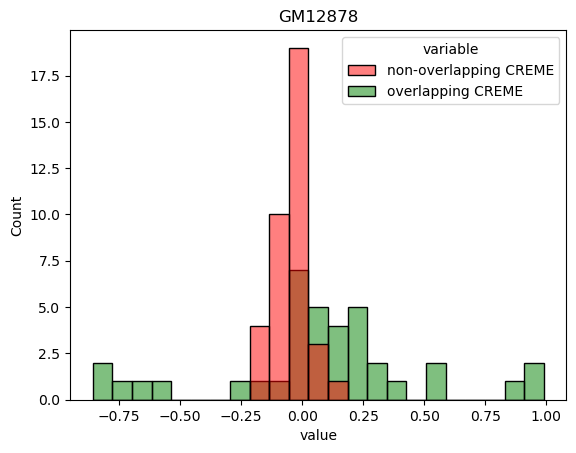

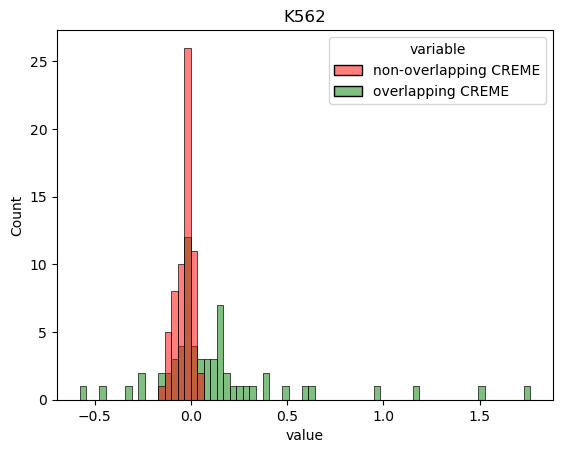

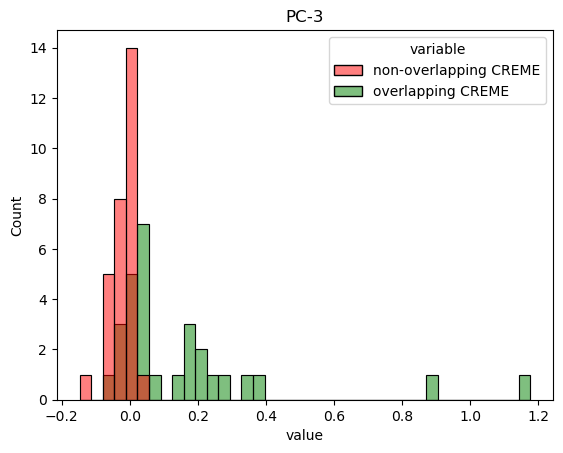

In [17]:
dfs = pd.read_csv(f'{csv_dir}/saliency_in_or_out_of_CREME_masks.csv', index_col='Unnamed: 0')
for cell_line, df in dfs.groupby('cell_line'):
    sns.histplot(data=df.iloc[:,:2].melt(), x='value', hue='variable', palette=['r', 'g'])
    plt.title(cell_line)
    # plt.savefig(f"{pdf_dir}/in_vs_out_saliency_{cell_line}.pdf")
    plt.show()


# EXAMPLE SALIENCY VS CREME VS XSTREME motifs

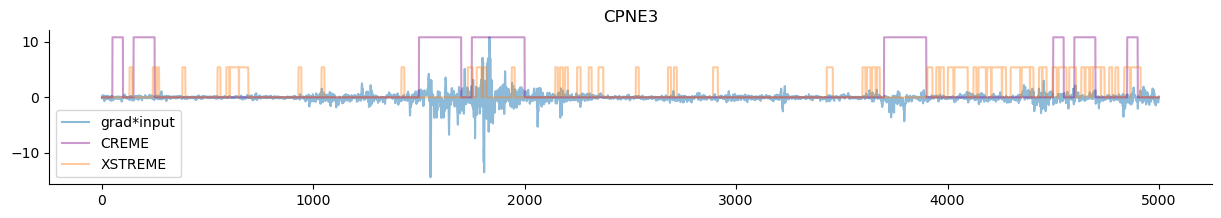

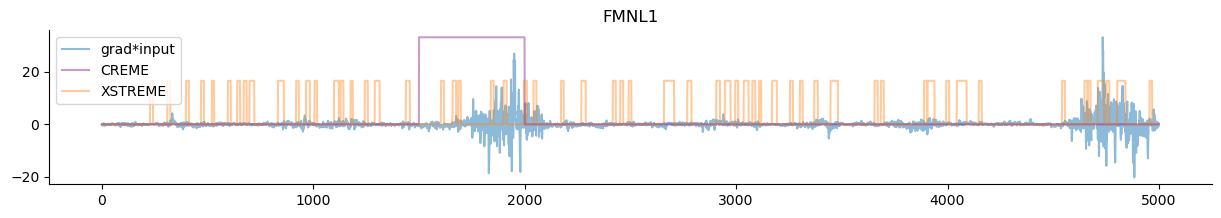

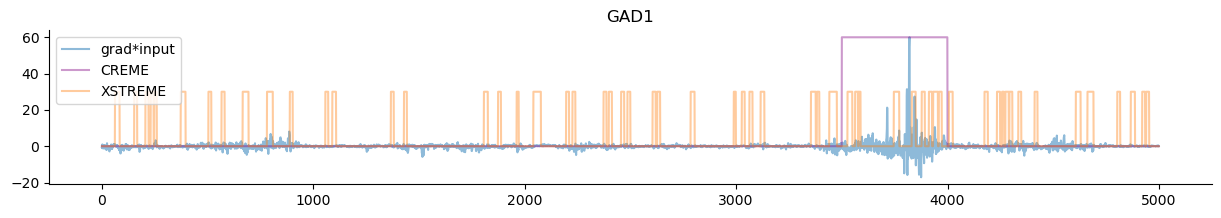

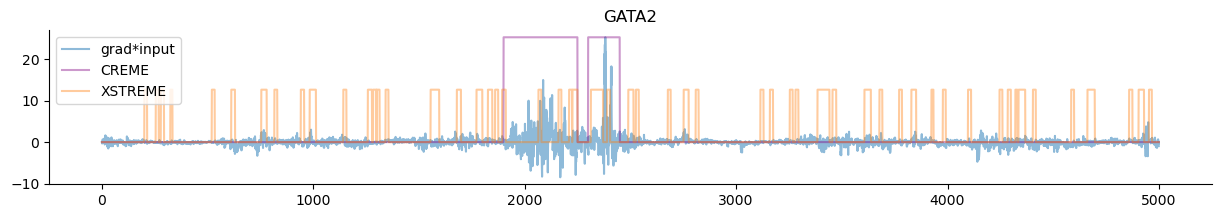

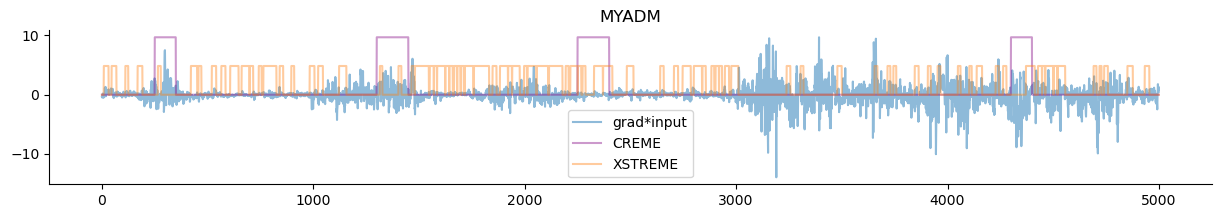

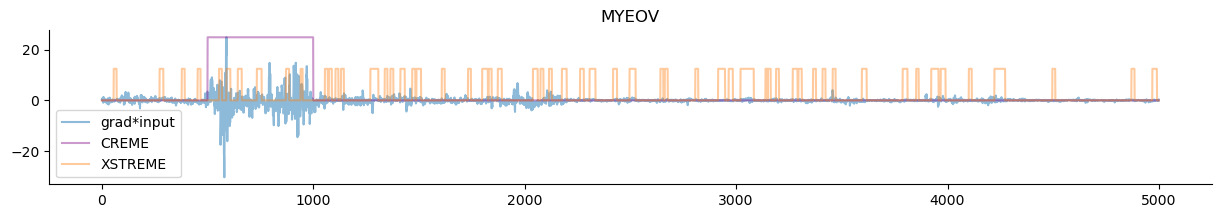

In [13]:
dfs = pd.read_csv(f'{csv_dir}/example_seqs.csv', index_col='Unnamed: 0')
for gene, df in dfs.groupby('gene'):
    
    fig, ax = plt.subplots(1, 1, figsize=[15, 2])
    ax.plot(df['Saliency'], alpha=0.5, label='grad*input')
    max_sal = np.max(df['Saliency'])
    
    ax.plot(df['CREME']*max_sal, label='CREME', color='purple', alpha=0.4)
    # plt.xlim(2000,2600)
    
    ax.plot([max_sal*0.5 if x else False for x in df['XSTREME']], label='XSTREME', alpha=0.4)
    
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(gene)
    plt.show()

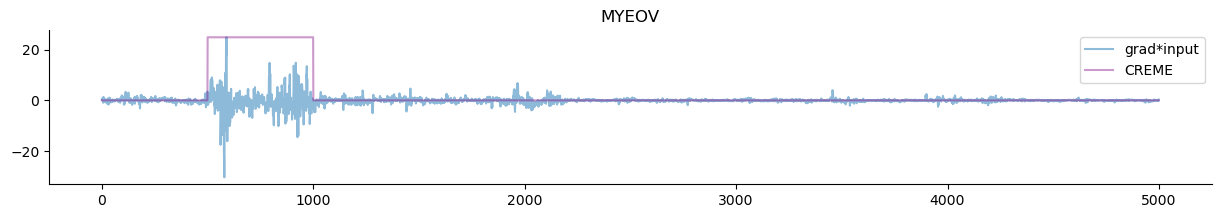

<Figure size 640x480 with 0 Axes>

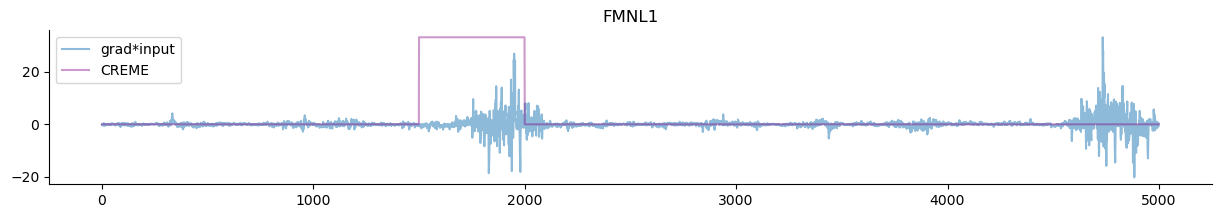

<Figure size 640x480 with 0 Axes>

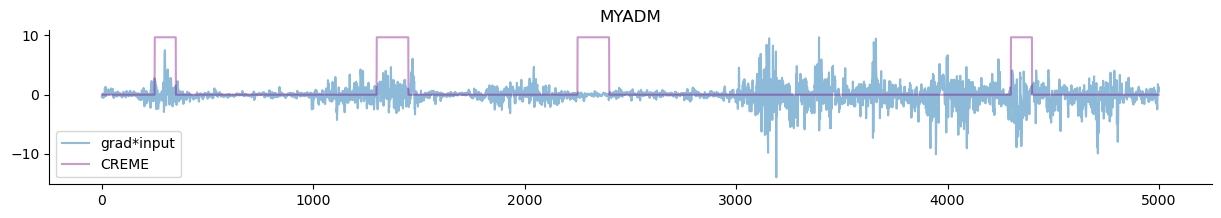

<Figure size 640x480 with 0 Axes>

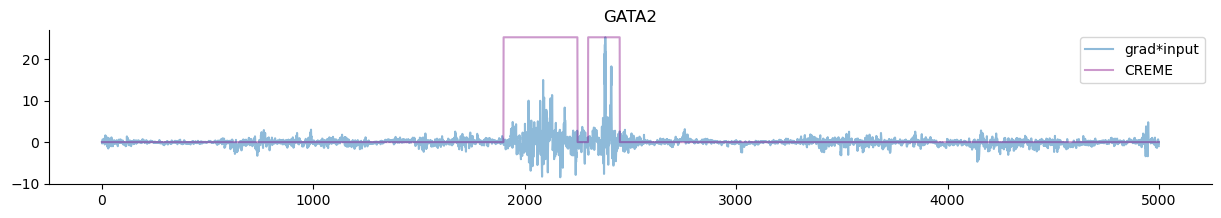

<Figure size 640x480 with 0 Axes>

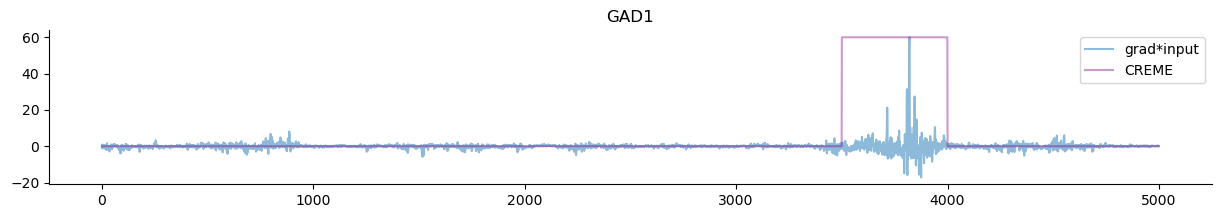

<Figure size 640x480 with 0 Axes>

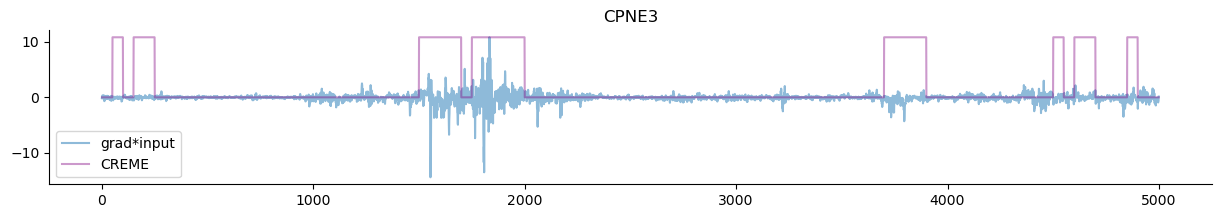

<Figure size 640x480 with 0 Axes>

In [130]:
for filename in os.listdir('../results/saliency/5111/'):
    if filename.split('_')[0] in ['GATA2', 'MYEOV', 'GAD1',
                                 'CPNE3', 'FMNL1', 'MYADM']:
        cre_saliency_scores, new_creme_mask = utils.plot_one_seq_feature_map(filename, model, seq_parser, 'K562', 5111, False)
        plt.savefig(f"{pdf_dir}/saliency_and_creme_{filename}.pdf")
        plt.show()